In [124]:
import requests
import time 
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [229]:
class StravaAPI:
    def __init__(self, client_id, client_secret, code=None):
        self.client_id = client_id
        self.client_secret = client_secret
        self.code = code
        self.read_all_url = f"https://www.strava.com/oauth/authorize?client_id={client_id}&redirect_uri=http://localhost/exchange_token&response_type=code&scope=read,activity:read_all&approval_prompt=force"
        self.activies_endpoint = "https://www.strava.com/api/v3/athlete/activities"
        self.activate_api_url = "https://www.strava.com/oauth/token"
    
    def connect(self):
        payload = {
            "client_id": self.client_id,
            "client_secret": self.client_secret,
            "code": self.code,
            "grant_type": "authorization_code"
        }

        tokens = requests.post(url=self.activate_api_url, data=payload).json() 
        refresh_token = tokens["refresh_token"]

        payload = {
            "client_id": self.client_id,
            "client_secret": self.client_secret,
            "grant_type": "refresh_token",
            "refresh_token": refresh_token
        }

        refreshed = requests.post(self.activies_endpoint, data=payload).json()
        access_token = tokens["access_token"]
        self.headers = {"Authorization": f"Bearer {access_token}"}

    def make_request(self, page, per_page):
        r = requests.get(self.activies_endpoint, headers=self.headers, params={"page":page, "per_page": per_page})
        activities = r.json()
        return activities

    def pull_activity_data(self, num_activities='all'):
        activities_list = []
        page = 1
        
        if num_activities == 'all':
            for _ in range(12):
                response = self.make_request(page=page, per_page=100)
                activities_list.extend(response)
                page+=1
        else:
            if num_activities >= 100:
                pages = num_activities // 100
                remainder = num_activities % 100
                for _ in range(pages-1):
                    response = self.make_request(page=page, per_page=100)
                    activities_list.extend(response)
                    page+=1
                
                response = self.make_request(page=pages, per_page=remainder)
                activities_list.extend(response)
            else:
                page = 1
                response = self.make_request(page=1, per_page=num_activities)
                activities_list.extend(response)
                page+=1

        self.activies_list = activities_list

In [230]:
test_obj = StravaAPI(client_id=186247, client_secret='0ae223d35225bb2f40f9b44a9a70ae18fd29169b')

In [231]:
test_obj.read_all_url

'https://www.strava.com/oauth/authorize?client_id=186247&redirect_uri=http://localhost/exchange_token&response_type=code&scope=read,activity:read_all&approval_prompt=force'

In [222]:
test_obj.code = '813248b2a8f605411e12492a9617a75b361c66bc'

In [223]:
test_obj.connect()

In [227]:
test_obj.pull_activity_data(num_activities=54)

In [228]:
test_obj.activies_list

[]

In [192]:
client_id = 186247
client_secret = "0ae223d35225bb2f40f9b44a9a70ae18fd29169b"
code = "38950215690b01f238ec5d1605c298bafa7136a2"

url = "https://www.strava.com/oauth/token"

payload = {
    "client_id": client_id,
    "client_secret": client_secret,
    "code": code,
    "grant_type": "authorization_code"
}

tokens = requests.post(url, data=payload).json()
print(tokens)

refresh_token = tokens["refresh_token"]

payload = {
    "client_id": client_id,
    "client_secret": client_secret,
    "grant_type": "refresh_token",
    "refresh_token": refresh_token
}

refreshed = requests.post(url, data=payload).json()

access_token = tokens["access_token"]

headers = {"Authorization": f"Bearer {access_token}"}

url = "https://www.strava.com/api/v3/athlete/activities"

activities_list = []

page = 1
for _ in range(12):
    r = requests.get(url, headers=headers, params={"page":page, "per_page": 100})
    activities = r.json()
    activities_list.extend(activities)
    page+=1

{'token_type': 'Bearer', 'expires_at': 1763858788, 'expires_in': 5023, 'refresh_token': '8b5a53d2c9d037f788eeac45b9394167bbe4127a', 'access_token': 'ad2ce494b330bae8fc5174e540d5894652ecbb93', 'athlete': {'id': 141225190, 'username': 'stagerb', 'resource_state': 2, 'firstname': 'Ben', 'lastname': 'Stager', 'bio': None, 'city': None, 'state': None, 'country': 'United States', 'sex': 'M', 'premium': False, 'summit': False, 'created_at': '2024-06-30T21:15:10Z', 'updated_at': '2025-09-11T16:38:37Z', 'badge_type_id': 0, 'weight': None, 'profile_medium': 'https://graph.facebook.com/7531584750286399/picture?height=256&width=256', 'profile': 'https://graph.facebook.com/7531584750286399/picture?height=256&width=256', 'friend': None, 'follower': None}}


KeyboardInterrupt: 

In [ ]:
import numpy as np

value = np.nan

# Check if the value is np.nan
if np.isnan(value):
    print("The value is np.nan")
else:
    print("The value is not np.nan")

In [149]:
def format_pace(x):
    if np.isnan(x):
        return 'NA'
    else:
        second_frac = x - int(x)
        seconds = int((60) * second_frac)
        if seconds < 10:
            seconds = f"0{seconds}"
        return f"{int(x)}:{seconds}"

In [150]:
all_keys = set().union(*[dic.keys() for dic in activities_list])

df = pd.DataFrame([{key: dic.get(key, None) for key in all_keys} for dic in activities_list])
df['date_str'] = df['start_date'].apply(lambda x: pd.Timestamp(x).date())
df['time_mins'] = df['elapsed_time'].apply(lambda x: x / 60)
df['distance_miles'] = df['distance'] * 0.000621371
df['pace'] = np.where(df['type'] == 'Run', df['time_mins'] / df['distance_miles'], np.nan)
df['pace_formatted'] = df['pace'].apply(format_pace)
df['speed_mph'] = df['distance_miles'] / (df['time_mins'] / 60)

In [154]:
df.to_csv("activity_data.csv")

In [151]:
df.to_csv

0        NA
1      8:01
2      7:59
3        NA
4      7:55
       ... 
392    6:32
393    6:22
394    6:25
395    6:21
396    5:54
Name: pace_formatted, Length: 397, dtype: object

In [130]:
df['pace']

0           inf
1      8.021714
2      7.993964
3           inf
4      7.917100
         ...   
392    6.545698
393    6.383113
394    6.433111
395    6.366447
396    5.909021
Name: pace, Length: 397, dtype: float64

<Axes: >

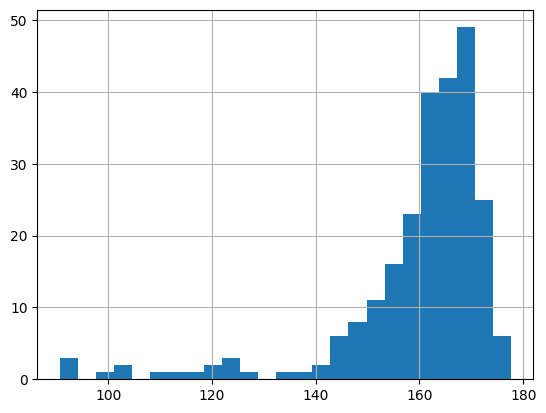

In [114]:
df['average_heartrate'].hist(bins=25)

In [ ]:
df